# A Fail-Safe Maximum Criticality Policy

In [1]:
from typing import List
import numpy as np

from domoku.tools import GomokuTools as gt
from domoku.data import create_binary_rep
from domoku.board import GomokuBoard

import tensorflow as tf

In [2]:
def print_bin(binary_sample):
    print(f'shape: {binary_sample.shape}')
    print(np.rollaxis(binary_sample, 2, 0)[0] + 2 * np.rollaxis(binary_sample, 2, 0)[1])

## Constant filters

We provide a factory class that creates initializers for various convolutional filters to be used in policies. Note that this is different from detectors that identify the mere existence.

Our filters identify the field that exploits the pattern.

In [3]:
class Gomoku9x9FilterFactory:

    def __init__(self):
        pass


    def get_sure_win_filters(self):
        return self.get_terminal_filters(channel=0)

    def get_must_defend_filters(self):
        return self.get_terminal_filters(channel=1)

    def get_terminal_filters(self, channel: int):
        """
        produces 9x9x2xN filter package for detection of the given channel
            ready for Tensorflow CNN initializers
        :param channel:
        :return:
        """
        filters = self._get_terminal_channel_filters()
        empty = np.zeros([9, 9], dtype=float)
        empty[4, 4] = -1  # penalty for a any occupied position
        zeros = np.stack([empty]*20)

        if channel == 0:
            return self._stack_and_roll(filters, zeros)
        elif channel == 1:
            return self._stack_and_roll(zeros, filters)
        else:
            raise ValueError('channel must be 0 or 1.')


    @staticmethod
    def _create_9x9_filter_set(line_pattern: List):
        """
        Creates 4 filters  for that pattern in any of the 4 general directions.
        :param line_pattern: a 1x9 pattern that shall be detected in four directions
        :return: a 9x9 constant initializer for a convnet to detect that pattern
        """
        empty = np.zeros([9, 9], dtype=float)
        horiz = empty.copy()
        horiz[4, :] = line_pattern
        vert = empty.copy()
        vert[:, 4] = line_pattern

        filters = np.array([
            vert,
            np.diag(line_pattern),
            horiz,
            np.diag(line_pattern)[::-1],
        ])

        return filters


    @staticmethod
    def _terminal_patterns():
        """
        :return: all line patterns that immediately terminate a game in the central position
        """
        return [
            [1, 1, 1, 1, -1, 0, 0, 0, 0],
            [0, 1, 1, 1, -1, 1, 0, 0, 0],
            [0, 0, 1, 1, -1, 1, 1, 0, 0],
            [0, 0, 0, 1, -1, 1, 1, 1, 0],
            [0, 0, 0, 0, -1, 1, 1, 1, 1],
        ]


    def _get_terminal_channel_filters(self):
        """
        All 20 different filters for a terminal thread on one channel
        :return:
        """
        channel_filters = np.array([
            self._create_9x9_filter_set(pattern)
            for pattern in self._terminal_patterns()
        ])
        combined = channel_filters.shape[0] * channel_filters.shape[1]
        channel_filters = channel_filters.reshape(combined, 9, 9)
        return channel_filters


    @staticmethod
    def _stack_and_roll(channel1, channel2):
        """
        rolls (2, N, 9, 9) -> (9, 9, 2, N)
        :param channel1: any 9x9xN list of filters for the first channel
        :param channel2: any 9x9xN list of filters for the second channel
        :return: filters, ready for tensorflow
        """
        res = np.stack([channel1, channel2])
        res = np.rollaxis(res, 0, 4)
        res = np.rollaxis(res, 0, 4)
        return res

In [4]:
factory = Gomoku9x9FilterFactory()
sure_win = factory.get_sure_win_filters()
must_def = factory.get_must_defend_filters()

---

### Smoke Test
#### Sure win = the pattern allows the current player to win with the next move.
All non-zero filter params are on the first channel
All zero filter params are on the second channel (observe the occupation penalty!)

In [5]:
print(sure_win.shape)
print(f"1st: {np.sum(sure_win[:,:,0,:])}")
print(f"2nd: {np.sum(sure_win[:,:,1,:])}")

(9, 9, 2, 20)
1st: 60.0
2nd: -20.0


# Now see it working!

In [6]:
class MaxCritPolicy(tf.keras.Model):
    """
    A policy that doesn't miss any sure-win or must-defend
    """
    def __init__(self, input_size, **kwargs):
        self.input_size = input_size
        super().__init__(**kwargs)

        filter_factory = Gomoku9x9FilterFactory()

        sure_win = filter_factory.get_sure_win_filters()
        must_def = filter_factory.get_must_defend_filters()

        self.sure_win_detector = tf.keras.layers.Conv2D(
            filters=20, kernel_size=(9, 9),
            kernel_initializer=tf.constant_initializer(sure_win),
            bias_initializer=tf.constant_initializer(-3),
            activation=tf.nn.relu,
            padding='same',
            input_shape=(input_size, input_size, 2))

        self.must_def_detector = tf.keras.layers.Conv2D(
            filters=20, kernel_size=(9, 9),
            kernel_initializer=tf.constant_initializer(must_def),
            bias_initializer=tf.constant_initializer(-3),
            activation=tf.nn.relu,
            padding='same',
            input_shape=(input_size, input_size, 2))

        self.combine = tf.keras.layers.Conv2D(
            filters=1, kernel_size=(1, 1),
            kernel_initializer=tf.constant_initializer(np.ones(20)),
            activation=tf.nn.relu)

    def call(self, sample):
        sample = np.reshape(sample, [-1, self.input_size, self.input_size, 2])
        sure_win = tf.squeeze(
            self.combine(self.sure_win_detector(sample)))
        must_def = tf.squeeze(
            self.combine(self.must_def_detector(sample)))
        return 2 * sure_win + must_def

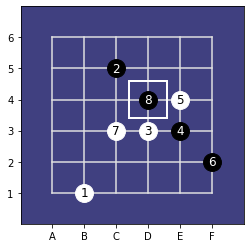

In [7]:
stones = gt.string_to_stones('b1c5d3e3e4f2c3d4')
board = GomokuBoard(n=6, disp_width=4, stones=stones)
board.display()

In [8]:
#sample = create_binary_rep(board, padding=4, border=True)
sample = create_binary_rep(board)
print_bin(sample)

shape: (6, 6, 2)
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 1. 0.]
 [0. 0. 1. 1. 2. 0.]
 [0. 0. 0. 0. 0. 2.]
 [0. 1. 0. 0. 0. 0.]]


In [9]:
policy = MaxCritPolicy(input_size=6)

2022-05-08 22:17:56.783386: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
res = policy(sample)
res

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [11]:
vec = tf.reshape(res, (1,-1))
tf.argmax(vec, axis=1)

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>

In [12]:
res[4, 2]

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [13]:
def suggest_greedy(sample):
    res = policy(sample)
    vec = tf.reshape(res, (1,-1))
    pos = tf.squeeze(tf.argmax(vec, axis=1))
    y = pos // 6
    x = pos - y * 6
    bx, by = gt.m2b((y, x), size=6)
    return chr(64 + bx) + str(by)

In [14]:
print(suggest_greedy(sample))

B6
